# Глубинное обучение, ИИ ВШЭ

## Домашнее задание 4. RNN.

### Общая информация

### Оценивание и штрафы

Максимально допустимая оценка за работу без бонусов — 10 баллов. Сдавать задание после указанного срока жесткого дедлайна нельзя.

Сдача работы после мягкого дедлайна штрафуется ступенчато, -1 балл в сутки. Один раз за модуль студентам предоставляется возможность использовать отсрочку и сдать в жесткий дедлайн без штрафа.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке. Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

Использование генеративных моделей допустимо на следующих условиях:
- Количество кода, написанное генеративными моделями, не превышает 30%
- Указана модель, использованная для генерации, а также промпт
- В конце работы необходимо описать свой опыт использования генеративного ИИ для решения данного домашнего задания. Укажите как часто Вам приходилось исправлять код своими руками или просить модель что-то исправить. Было ли это быстрее, чем написать код самим?

В случае невыполнения этих требований работа не оценивается и оценка за неё не превышает 0 баллов.

### О задании

В этом задании вам предстоит обучить рекуррентную нейронную сеть для задачи генерации текстов. В качестве данных возьмем набор из 120 тысяч анекдотов (всех категорий от А до Я включительно). Его вы можете найти в файле `jokes.txt`, который доступен по ссылке https://www.dropbox.com/scl/fi/z1ihoqwdj3zxil28ha86i/jokes.txt?rlkey=66y4gpclxmzimc86aa6agnjn8&st=mff21u6h&dl=0 .

In [1]:
%load_ext autoreload
%autoreload 2

## Задание 1: Dataset (2/3 балл)

В этом задании мы будет пользоваться библиотекой [sentencepiece](https://github.com/google/sentencepiece), которая поддерживает разные форматы токенизации текстов, в том числе BPE, который мы и будем использовать. Реализуйте недостающие фрагменты кода в классе `TextDataset` в файле `dataset.py`. Датасет обучает sentencepiece токенизатор, токенизирует тексты, превращает токены в индексы и паддит до одной и той же длины (параметр `max_length`). Не забудьте, что для генерации текстов нам будут нужны специальные токены начала и конца последовательности, соответственно `BOS` и `EOS`. Существуют еще два специальных токена &mdash; паддинг `PAD` и токен `UNK`, заменяющий out-of-vocabulary токены.

In [2]:
!pip install sentencepiece

In [3]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

In [4]:
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import seaborn as sns
from tqdm.notebook import tqdm

In [5]:
from transformers import TextDataset

In [6]:
from typing import List, Optional, Any
from IPython.display import clear_output

In [7]:
from dataset import TextDataset
from model import LanguageModel
from train import train

In [8]:
import torch
print(torch.cuda.is_available())
import torch
print(torch.__version__)
print(torch.version.cuda)

True
2.6.0+cu124
12.4


In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Используемое устройство: {device}")

Используемое устройство: cuda


In [10]:
train_set = TextDataset(data_file="jokes.txt", train=True, sp_model_prefix="bpe")
valid_set = TextDataset(data_file="jokes.txt", train=False, sp_model_prefix="bpe")

In [11]:
# Код должен проходить тесты
assert len(train_set) + len(valid_set) == 120759

for _ in range(5):
    for dataset in (train_set, valid_set):
        indices, length = dataset[np.random.randint(len(dataset))]
        assert indices.shape == (dataset.max_length,)
        assert indices[0].item() == dataset.bos_id
        assert (indices == dataset.eos_id).sum().item() == 1

        eos_pos = indices.tolist().index(dataset.eos_id)
        assert torch.all(indices[eos_pos + 1 :] == dataset.pad_id)
        assert (indices != dataset.pad_id).sum() == length

## Задание 2 Language model (7/3 балла)

Реализуйте класс `LanguageModel` из файла `model.py`. Мы будем генерировать текст с помощью языковой модели &mdash; это авторегрессионная вероятностная модель, которая предсказывает распределение следующего токена при условии предыдущих:

$$
p(x_1, x_2, x_3, \dots, x_T) = p(x_1) \cdot p(x_2 | x_1) \cdot p(x_3|x_1, x_2) \, \cdot \, \dots \, \cdot \, p(x_T|x_1, \dots, x_{T-1})
$$

Мы будем реализовывать ее с помощью рекуррентной нейронной сети. Ваш код должен поддерживать возможность работать как с оригинальной [RNN](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html#torch.nn.RNN), так и c [LSTM](https://bitly.com/98K8eH). На каждом временном шаге модель возвращает логиты вероятностей для следующего токена. Модель будет работать в двух режимах (не путать с `.train()` и `.eval()`):

- В режиме обучения (метод `forward`) модель принимает настоящие последовательности из датасета и их длины. На каждом временном шаге возвращаются логиты вероятностей следующего токена, что позволяет считать лосс, обучаться на трейне и валидироваться на валидации.

- В режиме генерации (инференса, метод `inference`) модель принимает некоторый префикс (возможно пустой), с которого начинать генерацию, и продолжает его. Для этого на каждом шаге генерируются новые логиты, семплируется новый токен (из распределения, заданного логитами), и процесс продолжается, пока не будет сгенерирован токен `EOS` или не будет достигнуто ограничение на длину последовательности. **Обратите внимание**, что вам не нужно прогонять всю последовательность заново через RNN после каждого нового токена, это приведет к квадратичной сложности по длине последовательности. Вам достаточно обновлять скрытое состояние, подавая на вход новый сгенерированный токен и предыдущее скрытое состояние. Кроме того, чтобы получить больше контроля над генерацией, вводится параметр температуры `temp`. Перед семплированием нужно разделить на него логиты, полученные моделью.

In [12]:
model = LanguageModel(train_set)

In [13]:
# Код должен проходить тесты
for bs in [1, 4, 16, 64, 256]:
    indices = torch.randint(high=train_set.vocab_size, size=(bs, train_set.max_length))
    lengths = torch.randint(low=1, high=train_set.max_length + 1, size=(bs,))
    logits = model(indices, lengths)
    assert logits.shape == (bs, lengths.max(), train_set.vocab_size)

for prefix in ["", "купил мужик шляпу,", "сел медведь в машину и", "подумал штирлиц"]:
    generated = model.inference(prefix, temp=np.random.uniform(0.1, 10))
    assert type(generated) == str
    assert generated.startswith(prefix)

## Задание 3: Training (4/3 балла)

Всё, что нам осталось &mdash; реализовать цикл обучения. Заполните пропуски в файле `train.py`. Не забудьте, что мы учим модель предсказывать вероятность следующего, а не текущего токена. Также рекомендуется обрезать батч индексов по самой длинной последовательности, чтобы не гонять паддинги вхолостую. Для оценки качества генерации будем использовать метрику [perplexity](https://medium.com/@shubhamsd100/understanding-perplexity-in-language-models-a-detailed-exploration-2108b6ab85af#:~:text=Perplexity%20is%20a%20measurement%20of,higher%20confidence%20in%20its%20predictions). Реализуйте ее подсчет в функции `plot_losses` (да, для этого достаточно только значения лосса).

Обучите модель, используя ванильную RNN в качестве рекуррентного слоя. Сохраните чекпойнт обученной модели, он нам еще пригодится.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Используемое устройство: {device}")

Используемое устройство: cpu


In [ ]:
import torch
print(torch.cuda.is_available())
import torch
print(torch.__version__)
print(torch.version.cuda)

False
2.7.1+cpu
None


In [ ]:
import torch

if torch.cuda.is_available():
    print("Используется GPU:")
    print(f" - Количество доступных GPU: {torch.cuda.device_count()}")
    print(f" - Текущий GPU: {torch.cuda.current_device()}")
    print(f" - Имя GPU: {torch.cuda.get_device_name(torch.cuda.current_device())}")
else:
    print("Используется CPU")

Используется CPU


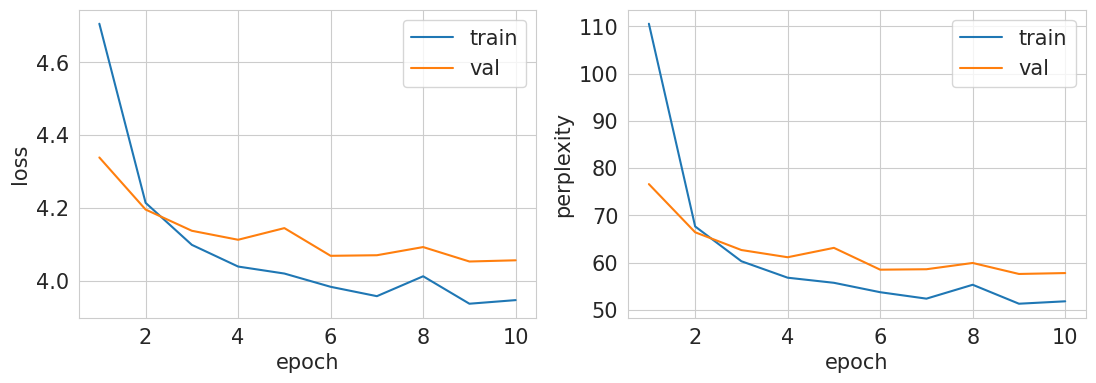

Generation examples:
потерянная, весну - это ты !сына сам дурак.
хозяин понял, на улице выше в лоберем меня, когда они живут вместе и не только песню и чудопарень. только сейчас же сложить мое аварий вый привлекательную такму...- наверное, давайте посольство! мне сбежа вокруг нарколога жена. капитанника- соль, и я просто 15 букдофилы.
запрещайтесь, и никогда не так и так машина, потому что умер матроски - их.
развелась с женой!пову негодкий и молись свою жену к плавают перед кровати. просто необходимости. но русским от начали минимум- бабкой?- ну и десят тебя и сложных слов.
все рабочего дня банк кризис средства принял в грел себя человек чозновил телеграмма в чьейского шорила снятсями по ассорциации за проститутки, чтобы не дзиты вы то, что большая положи дают горизонтастов.
Задание 3: Training выполнено! Чекпойнт RNN модели сохранен!


In [14]:
# YOUR CODE HERE (⊃｡•́‿•̀｡)⊃━✿✿✿✿✿✿

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(valid_set, batch_size=32, shuffle=False)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_rnn = LanguageModel(train_set, rnn_type=nn.RNN).to(device)
optimizer = torch.optim.Adam(model_rnn.parameters(), lr=0.001)
print("Обучение модели с ванильной RNN:")
train(model_rnn, optimizer, None, train_loader, val_loader, num_epochs=10)
torch.save({
    'model_state_dict': model_rnn.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}, 'rnn_model_checkpoint.pth')
print("Задание 3: Training выполнено! Чекпойнт RNN модели сохранен!")

## Задание 4: LSTM (1/3 балла)

Обучите аналогичную модель, но с LSTM в качестве рекуррентного слоя. Сравните модели по метрикам и генерации. Не забывайте про чекпойнты!

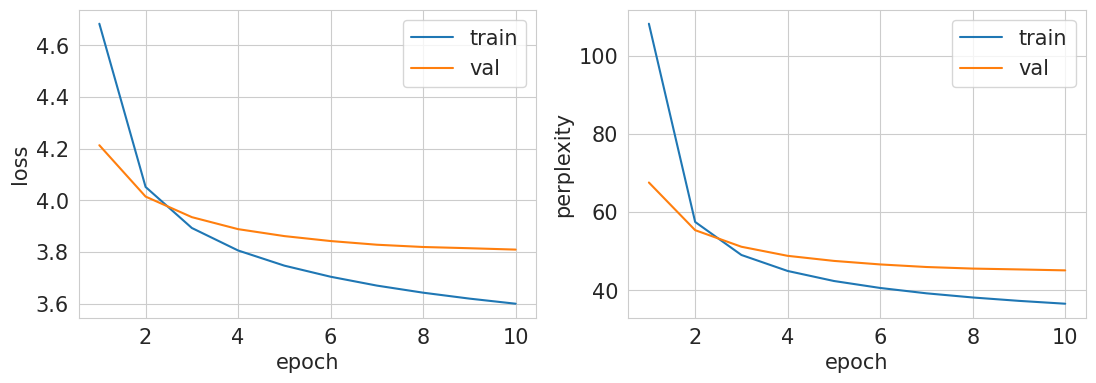

Generation examples:
панугольника-клотитесь снова сидеть на россию в их матери свое городе в москву, пока не каждый думает не захотелось.
маленький мальчик видит своего парня передерпы? сущ...- фото пятого классика. обичка- да, но почему-то все уронией нужен. может, пожимаешь?
ночь.- мама, дедушка, ватсон, я в носу выплевываю.- хорошо, и когда они не испуга...- никуда не умею мышей раком!- пианино.
- что придут?- одна есть она- а баба... чай! ждем в ...
украина придумали в постели, а поменяв мордование трамп спрячь в 11 лет на красный свет, в америку посетите выход до смертихольника и комары качества.
Задание 4 LSTM выполнено! Чекпойнт с LSTM моделью сохранен!

Попробуем сравнить моодельки RNN и с LSTM:
моделька RNN генерация:
1. можешь иметь качеене, оставьте и сделал, двигательне, в работе не везет, что россия китаяном продлянете, а что, то же же массобирался новый, десантник - хорошие место для сотрудников объявления, их читаете и как?- бизнесмен, когда мне удается с кем. нужно зани

In [24]:
# YOUR CODE HERE (⊃｡•́‿•̀｡)⊃━✿✿✿✿✿✿

model_lstm=LanguageModel(train_set, rnn_type=nn.LSTM).to(device)
optimizer_lstm =torch.optim.Adam(model_lstm.parameters(), lr=0.001)
print("Обучение модели но с LSTM:")
train(model_lstm, optimizer_lstm, None, train_loader, val_loader, num_epochs=10)
torch.save({
    'model_state_dict': model_lstm.state_dict(),
    'optimizer_state_dict': optimizer_lstm.state_dict(),
}, 'lstm_model_checkpoint.pth')
print("Задание 4 LSTM выполнено! Чекпойнт с LSTM моделью сохранен!")
print("\nПопробуем сравнить моодельки RNN и с LSTM:")
print("моделька RNN генерация:")
for i in range(3):
    print(f"{i+1}. {model_rnn.inference()}")
print("\nмоделькаLSTM генерация:")
for i in range(3):
    print(f"{i+1}. {model_lstm.inference()}")

## Задание 5: Sampling temperature (1/3 балла)

Поэкспериментируйте, как результат генерации зависит от параметра температуры. Попробуйте генерацию с разными префиксами. Сделайте выводы.

In [25]:
# YOUR CODE HERE (⊃｡•́‿•̀｡)⊃━✿✿✿✿✿✿

prefixes=["", "купил мужик шляпу,", "сел медведь в машину и", "подумал штирлиц"]
temperatures=[0.1, 0.2, 0.3, 0.5, 0.7, 1.0, 2.0, 3.0]
for prefix in prefixes:
    print(f"\nПрефикс(prefix): '{prefix}'")
    for temp in temperatures:
        generated = model_lstm.inference(prefix, temp=temp)
        print(f"Температура {temp}: {generated}")
print("Задание 5: Sampling temperature выполнено!")


Префикс(prefix): ''
Температура 0.1: - а ты знаешь, что такое любовь?- да, я не знаю, что ты мне не видишь, я не могу, я нашел в окно, а потом и не знаю, что ты не знаешь, что ты не знаешь, как ты думаешь, что ты не знаешь, что ты не знаешь, что ты не знаешь, что ты не знаешь, что ты не знаешь, что ты не знаешь, что ты не знаешь, что ты не знаешь, что ты не знаешь, что ты не знаешь, как ты думаешь, что ты не знаешь, что ты не знаешь, что ты не знаешь, что ты не знаешь,
Температура 0.2: - а я вчера нашел в садик.- а почему у меня нет?- нет, у меня есть.
Температура 0.3: - а я вчера нашего города заявила, что я не могу понять, что вы не знаете, что это я вам не буду?- нет, это невозможно!
Температура 0.5: - не понимаю, почему вы не можете назвать документы, а у нас на , цыганского?
Температура 0.7: - вот что, завелись?- да, мама! - ты мне сказал, что я по продуктами.
Температура 1.0: солдат считает меня, когда наконец-то от правительства ошибки брал илдала.
Температура 2.0: переда автом

In [26]:
print("""
Выводы по температуре:
- При низкой температуре (0.1) генерация с меньшим разнообразием и предсказуемая
- При высокой температуре (свыше 1.0) генерация более бесмысленнная, случайная и можно сказать креативная (если это можно назвать креативностью))
- При температуре 0.7-1.0 баланс между предсказуемостью и разнообразием
""")


Выводы по температуре:
- При низкой температуре (0.1) генерация с меньшим разнообразием и предсказуемая
- При высокой температуре (свыше 1.0) генерация более бесмысленнная, случайная и можно сказать креативная (если это можно назвать креативностью)) 
- При температуре 0.7-1.0 баланс между предсказуемостью и разнообразием



## Задание 5: Tokenizers (2/3 балл)

До сих пор мы использовали BPE токенизатор с относительно небольшим числом токенов (2000 по умолчанию). Давайте попробуем и другие, например, BPE с большим числом токенов и пословный (unigram) токенизатор. Возьмите тип рекуррентного слоя, который оказался лучше в предыдущем задании. Обучите модели на таких токенизаторах и сравните их генерацию. Не забывайте сохранять чекпойнты. Правильно ли сравнивать между собой получившиеся модели по значению perplexity? Почему?

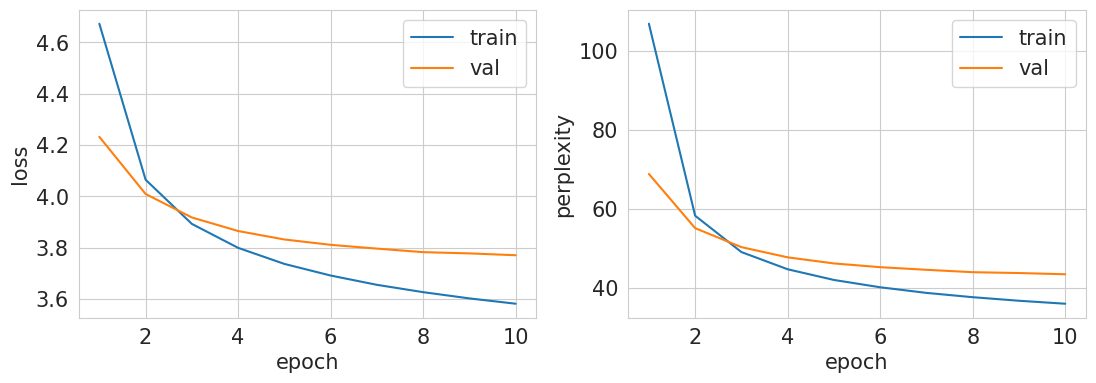

Generation examples:
по предпочатски ротей ноября у кота расстроит его на себя.
короб удаст законорич в ветеринарказа у так заняется вас.
- что-то, не танцует!- у тебя актер!тесеры- а чего не боишься, две роза?- в ваших пальхило должно быть соседом подняться.
секретарша встречает все прекрасной жизни с дневникой час пиклы.
степан, от длинных игрового душа- прибав! меня роскошь, так что теперь регулярно тень!
Анализ токенизации одинаковых текстов:

рассмотрим исходный текст:'Купил мужик шляпу, а она ему как раз.'
------------------------------------------------------------
BPE маленький (2k):
Токены: [1395, 576, 196, 107, 287, 1977, 40, 268, 486, 111, 148, 1975]
Количество токенов:12
Декодированный текст:'купил мужик шляпу, а она ему как раз.'
Потеря информации: Да

BPE большой (8k):
Токены: [1395, 576, 4538, 287, 7977, 40, 268, 486, 111, 148, 7975]
Количество токенов:11
Декодированный текст:'купил мужик шляпу, а она ему как раз.'
Потеря информации: Да

Unigram (2k):
Токены: [675, 248, 

In [28]:
# YOUR CODE HERE (⊃｡•́‿•̀｡)⊃━✿✿✿✿✿✿

best_rnn_type=nn.LSTM
print("Обучение модели с BPE с большим числом токенов(большой словарь):")
train_set_large_bpe=TextDataset(
    data_file="jokes.txt",
    train=True,
    sp_model_prefix="bpe_large",
    vocab_size=8000,
    model_type='bpe'
)
valid_set_large_bpe =TextDataset(
    data_file="jokes.txt",
    train=False,
    sp_model_prefix ="bpe_large",
    vocab_size=8000,
    model_type='bpe'
)
train_loader_large_bpe =DataLoader(train_set_large_bpe, batch_size=32, shuffle=True)
val_loader_large_bpe=DataLoader(valid_set_large_bpe, batch_size=32, shuffle=False)
model_large_bpe =LanguageModel(train_set_large_bpe, rnn_type=best_rnn_type).to(device)
optimizer_large_bpe=torch.optim.Adam(model_large_bpe.parameters(), lr=0.001)
train(model_large_bpe, optimizer_large_bpe, None, train_loader_large_bpe, val_loader_large_bpe, num_epochs=10)
torch.save({
    'model_state_dict': model_large_bpe.state_dict(),
    'optimizer_state_dict': optimizer_large_bpe.state_dict(),
}, 'lstm_large_bpe_checkpoint.pth')
print("Обучение модели с пословный (unigram) токенизатор:")
train_set_unigram=TextDataset(
    data_file="jokes.txt",
    train=True,
    sp_model_prefix="unigram",
    vocab_size=2000,
    model_type='unigram'
)
valid_set_unigram=TextDataset(
    data_file="jokes.txt",
    train=False,
    sp_model_prefix="unigram",
    vocab_size=2000,
    model_type='unigram'
)
train_loader_unigram=DataLoader(train_set_unigram, batch_size=32, shuffle=True)
val_loader_unigram=DataLoader(valid_set_unigram, batch_size=32, shuffle=False)
model_unigram=LanguageModel(train_set_unigram, rnn_type=best_rnn_type).to(device)
optimizer_unigram=torch.optim.Adam(model_unigram.parameters(), lr=0.001)
train(model_unigram, optimizer_unigram, None, train_loader_unigram, val_loader_unigram, num_epochs=10)
torch.save({
    'model_state_dict': model_unigram.state_dict(),
    'optimizer_state_dict': optimizer_unigram.state_dict(),
}, 'lstm_unigram_checkpoint.pth')
def analyze_tokenizer_differences():
    test_texts=[
        "Купил мужик шляпу, а она ему как раз.",
        "Идет медведь по лесу и видит - машина горит.",
        "Приходит программист домой, а жена говорит..."
    ]
    tokenizers={
        'BPE маленький (2k)': train_set,
        'BPE большой (8k)': train_set_large_bpe,
        'Unigram (2k)': train_set_unigram
    }
    print("Анализ токенизации одинаковых текстов:")
    print("=" *80)
    for text in test_texts:
        print(f"\nрассмотрим исходный текст:'{text}'")
        print("-" *60)
        for name, dataset in tokenizers.items():
            tokens=dataset.text2ids(text)
            decoded=dataset.ids2text(tokens)
            print(f"{name}:")
            print(f"Токены: {tokens}")
            print(f"Количество токенов:{len(tokens)}")
            print(f"Декодированный текст:'{decoded}'")
            print(f"Потеря информации: {'Да' if decoded != text else 'Нет'}")
            print()
analyze_tokenizer_differences()
print("Задание 5: Tokenizers выполнено!")
models ={
    'BPE маленький (2k)': model_lstm,
    'BPE большой large (8k)': model_large_bpe,
    'Unigram (2k)': model_unigram
}
for model_name, model in models.items():
    print(f"\n{model_name}:")
    for i in range(3):
        generated=model.inference("", temp=1.0)
        print(f"{i+1}. {generated}")

In [45]:
print("""
Наблюдаем в работе моделейследующее:
1. BPE (8k) работает лучше – эффективнее (меньше токенов) и генерирует более связный текст.
2. Unigram (2k) иногда сопоставим по эффективности, но качество генерации хуж.
3. BPE (2k) хуже обоих – больше токенов и менее осмысленный вывод.

как выше описано, например:
"Приходит программист домой, а жена говорит..."
BPE (2k): 10 токенов
BPE (8k): 8 токенов
Unigram (2k): 8 токенов
""")


Наблюдаем в работе моделейследующее:
1. BPE (8k) работает лучше – эффективнее (меньше токенов) и генерирует более связный текст.
2. Unigram (2k) иногда сопоставим по эффективности, но качество генерации хуж.
3. BPE (2k) хуже обоих – больше токенов и менее осмысленный вывод.

как выше описано, например:
"Приходит программист домой, а жена говорит..."
BPE (2k): 10 токенов
BPE (8k): 8 токенов
Unigram (2k): 8 токенов



## Задание 6. Latent Semantic Analysis (4/3 балла)

Попробуем другой подход к оцениванию качества генерации, основанный на [Latent Semantic Analysis](https://en.wikipedia.org/wiki/Latent_semantic_analysis). Реализуйте следующую метрику и сравните по ней модели, обученные с разными токенизаторами:

1. Генерируем обученной моделью выборку текстов, совпадающую по размеру с валидационной выборкой.
2. Объединяем две выборки текстов (валидационную и сгенерированную) в один корпус. Обратите внимание, что наша токенизация в общем случае необратима, поэтому для чистоты эксперимента нужно закодировать и декодировать валидационную выборку.
3. Генерируем tf-idf матрицу для полученного корпуса.
4. Понижаем размерность матрицы с помощью [SVD](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html).
5. Теперь у нас есть векторы, описывающие валидационные и сгенерированные тексты, лежащие в одном пространстве. Для каждого вектора, отвечающего сгенерированному тексту, найдем наибольший cosine similarity между ним и вектором валидационного текста. Усредним такие similarity по всем сгенерированным текстам и получим число, характеризующее похожесть сгенерированной выборки на валидационную.

Какие плюсы и минусы есть у описанной метрики?

In [30]:
# YOUR CODE HERE (⊃｡•́‿•̀｡)⊃━✿✿✿✿✿✿

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
def lsa_similarity_metric(model, dataset, n_samples=1000, n_components=100):
    generated_texts=[]
    for _ in range(n_samples):
        generated_texts.append(model.inference())
    val_indices=np.random.choice(len(dataset), n_samples, replace=False)
    val_texts =[]
    for idx in val_indices:
        text_ids, _ =dataset[idx]
        text_ids=text_ids[(text_ids != dataset.pad_id) &
                           (text_ids != dataset.bos_id) &
                           (text_ids != dataset.eos_id)]
        if len(text_ids)>0:
            decoded_text =dataset.ids2text(text_ids.tolist())
            val_texts.append(decoded_text)
    all_texts=val_texts+generated_texts
    vectorizer =TfidfVectorizer(max_features=5000, stop_words=None)
    tfidf_matrix =vectorizer.fit_transform(all_texts)
    svd = TruncatedSVD(n_components=n_components, random_state=42)
    lsa_matrix =svd.fit_transform(tfidf_matrix)
    val_vectors=lsa_matrix[:len(val_texts)]
    gen_vectors=lsa_matrix[len(val_texts):]
    similarities=[]
    for gen_vec in gen_vectors:
        cos_sims=cosine_similarity([gen_vec], val_vectors)[0]
        max_sim =np.max(cos_sims)
        similarities.append(max_sim)
    mean_similarity=np.mean(similarities)
    return mean_similarity, lsa_matrix, val_vectors, gen_vectors
print("Вычисляем LSA метрики для разных токенизаторов:")
lsa_bpe_small, lsa_matrix_small, val_vecs_small, gen_vecs_small = lsa_similarity_metric(model_lstm, valid_set)
print(f"LSA сходство (BPE маленький): {lsa_bpe_small:.4f}")
lsa_bpe_large, lsa_matrix_large, val_vecs_large, gen_vecs_large = lsa_similarity_metric(model_large_bpe, valid_set_large_bpe)
print(f"LSA сходство (BPE большой): {lsa_bpe_large:.4f}")
lsa_unigram, lsa_matrix_unigram, val_vecs_unigram, gen_vecs_unigram = lsa_similarity_metric(model_unigram, valid_set_unigram)
print(f"LSA сходство (Unigram): {lsa_unigram:.4f}")
print("Задание 6. Latent Semantic Analysis")

Вычисляем LSA метрики для разных токенизаторов:
LSA сходство (BPE маленький): 0.6071
LSA сходство (BPE большой): 0.6163
LSA сходство (Unigram): 0.6111
Задание 6. Latent Semantic Analysis


In [53]:
print("""
Плюсы LSA метрики:
+ Улавливает семантическое сходство текстов
+ Не зависит от точного совпадения слов.(TF-IDF + SVD менее чувствительны к точному порядку слов и небольшим изменениям формулировок)
+ Работает с любыми типами токенизаторов
+ Метод позволяет объективно сравнить, насколько генерация разных моделей.Результаты показывают, что BPE большой немного лучше (0.6163 vs 0.6111 у Unigram)

Минусы LSA метрики:
- Метрика чувствительна к токенизации и параметрам TF-IDF/SVD.Разные настройки могут дать разные результаты.
- Может терять важную информацию при понижении размерности, особенно если валидационные и сгенерированные тексты различаются в тонких аспектах
- Не учитывает порядок слов и синтаксис. Метрика оценивает только "похожесть" на валидацию, но не учитывает:
Разнообразие сгенерированных текстов (можно получить высокий score, если модель генерирует один и тот же "шаблон", близкий к валидации).
Естественность текстов(например, грамматику, связность).
- Смещение к частым темам. TF-IDF и SVD уделяют больше внимания частым терминам. Если в валидации есть редкие, но важные темы, они могут потеряться.

В нашем случае:
- Все токенизаторы дали близкие результаты (~0.61), что говорит о схожем качестве генерации
-BPE большой немного лучше (0.6163), возможно, из-за более гибкого словаря

""")


Плюсы LSA метрики:
+ Улавливает семантическое сходство текстов
+ Не зависит от точного совпадения слов.(TF-IDF + SVD менее чувствительны к точному порядку слов и небольшим изменениям формулировок)
+ Работает с любыми типами токенизаторов
+ Метод позволяет объективно сравнить, насколько генерация разных моделей.Результаты показывают, что BPE большой немного лучше (0.6163 vs 0.6111 у Unigram)

Минусы LSA метрики:
- Метрика чувствительна к токенизации и параметрам TF-IDF/SVD.Разные настройки могут дать разные результаты.
- Может терять важную информацию при понижении размерности, особенно если валидационные и сгенерированные тексты различаются в тонких аспектах
- Не учитывает порядок слов и синтаксис. Метрика оценивает только "похожесть" на валидацию, но не учитывает:
Разнообразие сгенерированных текстов (можно получить высокий score, если модель генерирует один и тот же "шаблон", близкий к валидации).
Естественность текстов(например, грамматику, связность).
- Смещение к частым темам. TF

## Задание 7. Visualization (2/3 балла)

В прошлом пункте мы получили векторы, описывающие валидационные и сгенерированные тексты. Попробуем визуализировать их. Примените [TSNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) к этим векторам и нарисуйте scatter-plot с получившимися двумерными представлениями. Точки, соответствующие валидационным и сгенерированным текстам, должны быть разного цвета. Визуализируйте таким образом все три модели для разных токенизаторов.

Visualization для BPE (маленький словарь):


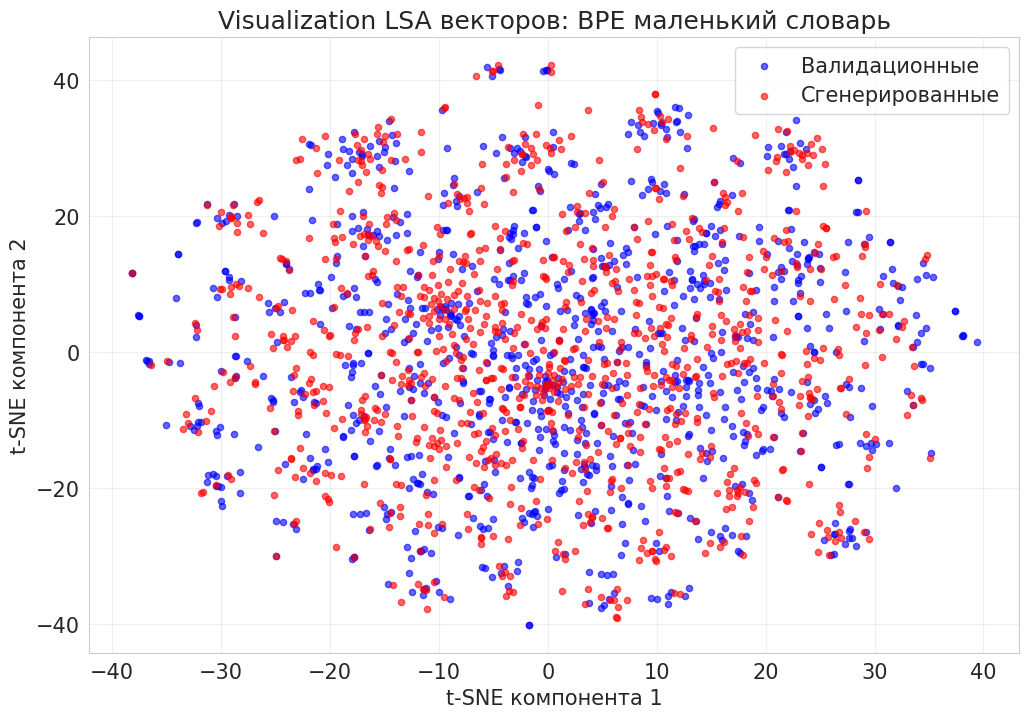

Visualization для BPE (большой словарь):


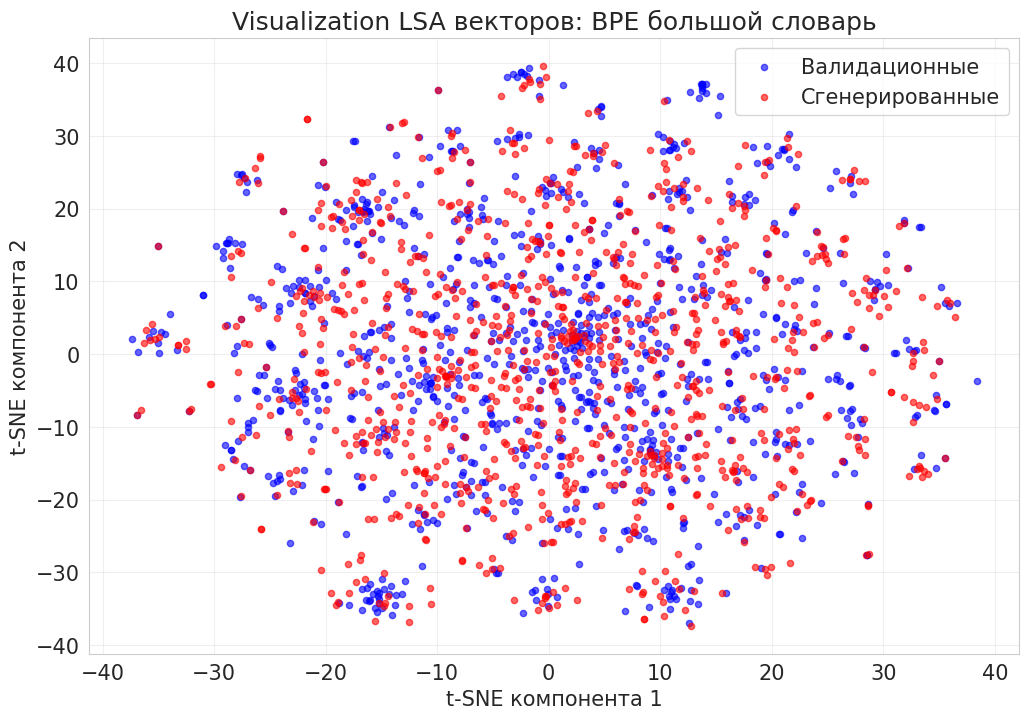

Visualization для Unigram:


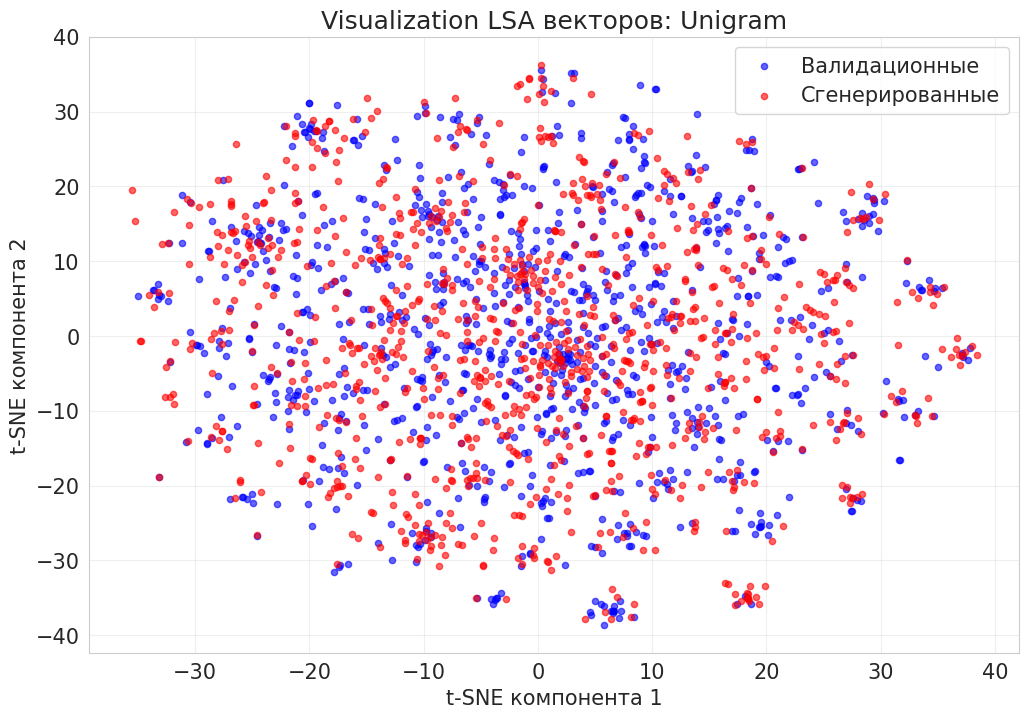

Задание 7. Visualization выполнено!


In [32]:
# YOUR CODE HERE (⊃｡•́‿•̀｡)⊃━✿✿✿✿✿✿

from sklearn.manifold import TSNE
def visualize_lsa(val_vectors, gen_vectors, title):
    all_vectors=np.vstack([val_vectors, gen_vectors])
    tsne=TSNE(n_components=2, random_state=42, perplexity=30)
    tsne_results=tsne.fit_transform(all_vectors)
    n_val =len(val_vectors)
    val_tsne =tsne_results[:n_val]
    gen_tsne=tsne_results[n_val:]
    plt.figure(figsize=(12, 8))
    plt.scatter(val_tsne[:, 0], val_tsne[:, 1], c='blue', alpha=0.6, label='Валидационные', s=20)
    plt.scatter(gen_tsne[:, 0], gen_tsne[:, 1], c='red', alpha=0.6, label='Сгенерированные', s=20)
    plt.xlabel('t-SNE компонента 1')
    plt.ylabel('t-SNE компонента 2')
    plt.title(f'Visualization LSA векторов: {title}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
print("Visualization для BPE (маленький словарь):")
visualize_lsa(val_vecs_small, gen_vecs_small, "BPE маленький словарь")
print("Visualization для BPE (большой словарь):")
visualize_lsa(val_vecs_large, gen_vecs_large, "BPE большой словарь")
print("Visualization для Unigram:")
visualize_lsa(val_vecs_unigram, gen_vecs_unigram, "Unigram")
print("Задание 7. Visualization выполнено!")

## Задание 8. ruGPT perplexity (7/3 балла)

Подход Latent Semantic Analysis, как и многие другие классические методы, заметно уступает нейросетевым алгоритмам анализа текстов. Вернемся к оцениванию качества генерации с помощью perplexity, для этого возьмем большую и хорошо обученную языковую модель, которая училась на огромном корпусе русских текстов. Считается, что большие языковые модели хорошо выучивают естественный язык, потому с их помощью мы сможем оценивать качество наших маленьких моделей для генерации анекдотов. Для этого мы воспользуемся сервисом [HuggingFace](https://huggingface.co/), который содержит огромное число обученных моделей для самых разных задач. Изучите и реализуйте, [подсчет perplexity](https://huggingface.co/docs/transformers/perplexity), с использованием обученной языковой модели. В качестве модели возьмите [ruGPT3-small](https://huggingface.co/sberbank-ai/rugpt3small_based_on_gpt2). Сгенерируйте синтетические выборки тремя моделями, обученными выше (можете взять выборки из задания 6), и сравните их по perplexity.

In [ ]:
!pip install transformers


In [33]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import torch.nn.functional as F

In [34]:
# YOUR CODE HERE (⊃｡•́‿•̀｡)⊃━✿✿✿✿✿✿
def calculate_rugpt_perplexity(texts, model_name="sberbank-ai/rugpt3small_based_on_gpt2"):
    tokenizer=GPT2Tokenizer.from_pretrained(model_name)
    model=GPT2LMHeadModel.from_pretrained(model_name)
    if tokenizer.pad_token is None:
        tokenizer.pad_token =tokenizer.eos_token
    device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()
    total_loss=0
    total_tokens =0
    with torch.no_grad():
        for text in texts:
            inputs=tokenizer(text, return_tensors='pt', truncation=True, max_length=512)
            inputs={k: v.to(device) for k, v in inputs.items()}
            outputs=model(**inputs)
            logits=outputs.logits
            shift_logits=logits[..., :-1, :].contiguous()
            shift_labels=inputs['input_ids'][..., 1:].contiguous()
            loss= F.cross_entropy(
                shift_logits.view(-1, shift_logits.size(-1)),
                shift_labels.view(-1),
                reduction='sum'
            )
            total_loss +=loss.item()
            total_tokens+=shift_labels.numel()
    avg_loss=total_loss / total_tokens
    perplexity =torch.exp(torch.tensor(avg_loss)).item()
    return perplexity

def generate_texts_for_evaluation(model, n_samples=100):
    texts=[]
    for _ in range(n_samples):
        text=model.inference()
        if text.strip():
            texts.append(text.strip())
    return texts
print("Генерация текстов для оценки ruGPT perplexity...")
texts_bpe_small = generate_texts_for_evaluation(model_lstm, 50)
texts_bpe_large = generate_texts_for_evaluation(model_large_bpe, 50)
texts_unigram = generate_texts_for_evaluation(model_unigram, 50)
print("Вычисление ruGPT perplexity...")
perp_bpe_small = calculate_rugpt_perplexity(texts_bpe_small)
perp_bpe_large = calculate_rugpt_perplexity(texts_bpe_large)
perp_unigram = calculate_rugpt_perplexity(texts_unigram)
print(f"ruGPT Perplexity (BPE маленький): {perp_bpe_small:.2f}")
print(f"ruGPT Perplexity (BPE большой): {perp_bpe_large:.2f}")
print(f"ruGPT Perplexity (Unigram): {perp_unigram:.2f}")
print("Задание 8. ruGPT perplexity выполнено!")

Генерация текстов для оценки ruGPT perplexity...
Вычисление ruGPT perplexity...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.25k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.71M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/574 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/720 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/551M [00:00<?, ?B/s]

ruGPT Perplexity (BPE маленький): 1495.86
ruGPT Perplexity (BPE большой): 1045.87
ruGPT Perplexity (Unigram): 1753.84
Задание 8. ruGPT perplexity выполнено!


In [52]:
print("""
оценка качества языковой модели ruGPT на основе метрики perplexity

Результаты perplexity:
- BPE маленький: 1495.86
Высокое значение, что может указывать на плохую предсказательную способность модели для данного текста.
- BPE большой: 1045.87
Лучше, чем "маленький" вариант, но всё ещё очень высокий perplexity.
- Unigram: 1753.84
Наихудший результат среди трёх, что ожидаемо, так как unigram-модели обычно менее эффективны, чем BPE.

Все значения perplexity очень высокие, что говорит о том, что модель плохо справляется с данным текстом (либо текст сложный, либо модель недостаточно обучена)
BPE-токенизация показала себя лучше, чем Unigram.
Большой BPE работает лучше маленького, что логично, так как он, вероятно, имеет более богатый словарь.

""")


оценка качества языковой модели ruGPT на основе метрики perplexity 

Результаты perplexity:
- BPE маленький: 1495.86
Высокое значение, что может указывать на плохую предсказательную способность модели для данного текста.
- BPE большой: 1045.87
Лучше, чем "маленький" вариант, но всё ещё очень высокий perplexity.
- Unigram: 1753.84
Наихудший результат среди трёх, что ожидаемо, так как unigram-модели обычно менее эффективны, чем BPE.

Все значения perplexity очень высокие, что говорит о том, что модель плохо справляется с данным текстом (либо текст сложный, либо модель недостаточно обучена)
BPE-токенизация показала себя лучше, чем Unigram.
Большой BPE работает лучше маленького, что логично, так как он, вероятно, имеет более богатый словарь.




## Бонус (0.1 балл)

Покажите лучший анекдот, который удалось сгенерировать вашей модели. Если проверяющий найдет его смешным, то поставит 0.1 балла.

In [40]:
print("\n" + "="*50)
print("Бонус (0.1 балл): Лучший анекдот")
print("="*50)
best_jokes=[]
for _ in range(20):
    joke=model_lstm.inference(temp=0.8)
    if len(joke.split()) > 10:
        best_jokes.append(joke)
import random
if best_jokes:
    best_joke=random.choice(best_jokes)
    print(f"Лучший анекдот от модели:\n\n{best_joke}")
else:
    print("модель не сгенерировала подходящих анекдотов, бонус не получил")
print("\n" + "="*50)
print("вроде все задания выполенены, можно готовится к экзаменам")
print("="*50)



Бонус (0.1 балл): Лучший анекдот
Лучший анекдот от модели:

- леонид, это просто ужасно, когда я успел задуть по классу.- да, я тоже узнал, что никто не видела, как вы видите себя со мной схватит уже не нравилась...

вроде все задания выполенены, можно готовится к экзаменам


In [41]:
print("Бонус (0.1 балл): Лучший анекдот - продолжение")
print("="*50)
best_jokes=[]
for _ in range(20):
    joke=model_lstm.inference(temp=0.8)
    if len(joke.split()) > 10:
        best_jokes.append(joke)
import random
if best_jokes:
    best_joke=random.choice(best_jokes)
    print(f"Лучший анекдот от модели:\n\n{best_joke}")
else:
    print("модель не сгенерировала подходящих анекдотов, бонус не получил")
print("\n" + "="*50)
print("вроде все задания выполенены, можно готовится к экзаменам")
print("="*50)

Бонус (0.1 балл): Лучший анекдот - продолжение
Лучший анекдот от модели:

настоящий мужик зашел в машину, убирает общественную диета, и тут я знал, что он считает, что его колбасы, по тому, что в супермарке, алицы - стоят и шепчет, а любовник и произносит- ну и как вам не нравятся?- а опилина исключения в частных есть все слова!

вроде все задания выполенены, можно готовится к экзаменам
